# Часть 1. Vanilla Autoencoder (9 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

d:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

In [4]:
numpy_attrs = attrs.to_numpy()

In [5]:
print(len(numpy_attrs))
print(len(data))

13143
13143


Фиксируем seed

In [6]:
SEED = 42


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [7]:
# train test split
from sklearn.model_selection import train_test_split

train_img, test_img, train_attr, test_attr = train_test_split(data, numpy_attrs, train_size=0.9, shuffle=False)

In [8]:
print(len(train_img), len(train_attr))

11828 11828


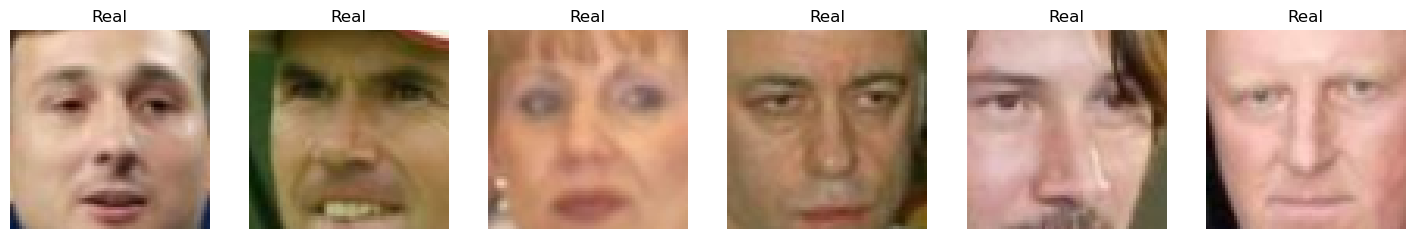

In [9]:
#show 
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    rand_ind = np.random.randint(0,  len(train_img)+ 1)
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(train_img[rand_ind])
    plt.title('Real')
plt.show();

Make an DataLoader

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [11]:
class MaDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels.astype(np.float16)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
           return self.transform(self.data[idx]), torch.from_numpy(self.labels[idx])
        return self.data[idx], self.labels[idx] 


In [12]:

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5] 

transform_normalize = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=mean, std=std)
])

In [13]:
train_ds = MaDataset(train_img, train_attr, transform=transform_normalize)
test_ds = MaDataset(test_img, test_attr, transform=transform_normalize)

In [14]:
x, y = train_ds[0]
print(type(x)) 
print(type(y)) 

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [15]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


### Conv AE

In [16]:
class ConvNormBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, padding = 1, stride = 1, is_last_block=False):
        super().__init__()
        self.is_last_block = is_last_block

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if not self.is_last_block:
            x = self.relu(x)
        return x

In [17]:
class SimpleConvNormBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, padding = 1, stride = 1, is_last_block=False):
        super().__init__()
        self.is_last_block = is_last_block

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)

        if not self.is_last_block:
            x = self.relu(x)
        return x

In [18]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ConvNormBlock(3, 128),
            ConvNormBlock(128, 64),
            ConvNormBlock(64, dim_code) #dim_code 32
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dim_code, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [19]:
def show_ae(model, dataset, clr_output=True):
    if clr_output:
        clear_output(wait=True)
    model.eval()
    plt.figure(figsize=(12, 6))
    for i in range(6):
         
        real_img, label = dataset[i]
        with torch.no_grad():
            ae_img, latent = model(torch.unsqueeze(real_img.to(device, dtype=torch.float), 0))
        ae_img = ae_img[0].cpu()
        
        t_std = torch.tensor(std).view(3, 1, 1)
        t_mean = torch.tensor(mean).view(3, 1, 1)

        real_img = real_img * t_std + t_mean
        ae_img = ae_img * t_std + t_mean

        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(real_img.permute(1, 2, 0))
        plt.title('Real')

        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.imshow(ae_img.permute(1, 2, 0))
        plt.title('AE res')

    plt.show()

In [20]:
device = torch.device('cuda')

In [21]:
from IPython.display import clear_output
def train_ae(autoencoder, train_dl, optimizer, criterion , test_dl, n_epochs, test_ds, show_in_epo=True):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        
        autoencoder.train()
        train_losses_per_epoch = []

        for i, (x_batch, y_batch) in enumerate(train_dl):

            x_batch = x_batch.to(device, dtype=torch.float)
            y_batch = y_batch.to(device, dtype=torch.float)

            optimizer.zero_grad()
            reconstruction, latent = autoencoder(x_batch)
            #reconstruction = reconstruction.view(-1, 64, 64, 3)
            
            loss = criterion(reconstruction, x_batch)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

            if show_in_epo and (i % 50 == 0) :
                show_ae(autoencoder, test_ds)
                autoencoder.train()

        train_losses.append(np.mean(train_losses_per_epoch))

        autoencoder.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for x_batch, y_batch in test_dl:
                x_batch = x_batch.to(device, dtype=torch.float)
                y_batch = y_batch.to(device, dtype=torch.float)

                reconstruction, latent = autoencoder(x_batch)
                #reconstruction = reconstruction.view(-1, 64, 64, 3)
                loss = criterion(x_batch, reconstruction)
                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))
        #show
        show_ae(autoencoder, test_ds)
        print(f'epo {epoch+1}/{n_epochs}')
    return train_losses, val_losses

С MSELoss ом

In [22]:


class  BCELinearAE(nn.Module):
    def __init__(self, n_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*64*64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 258),
            nn.ReLU(),
            nn.Linear(258, n_dim) # Latent dim size
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_dim, 258),
            nn.ReLU(),
            nn.Linear(258, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*64*64)#,
            #nn.Sigmoid()
        )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code).view(-1, 3, 64, 64)
        return reconstruction, latent_code


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


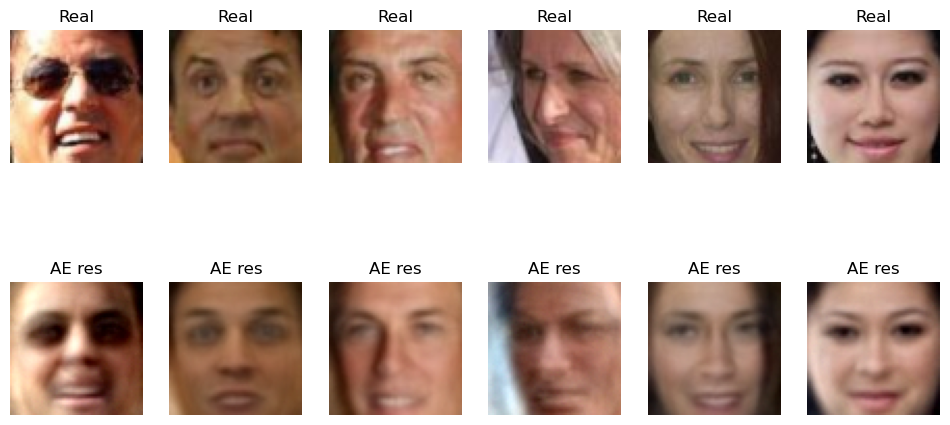

epo 30/30


In [23]:
bce_lin_ae = BCELinearAE(n_dim=128)
bce_lin_ae.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(bce_lin_ae.parameters(), lr=3e-4)

n_epochs = 30
train_losses, val_losses = train_ae(autoencoder=bce_lin_ae, train_dl=train_dl,
                                    test_dl=test_dl, criterion=criterion,
                                    optimizer=optimizer, n_epochs=n_epochs, test_ds=test_ds, show_in_epo=False)

С BCELoss ошибка cuda  
я пробовал использовать флаттен чтобы выпрямить векторы x_batch reconstructed прогонял через БЦЕ и потом назад делал из них Тензоры прежнего размера

In [25]:


class  BCELinearAE(nn.Module):
    def __init__(self, n_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*64*64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 258),
            nn.ReLU(),
            nn.Linear(258, n_dim) # Latent dim size
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_dim, 258),
            nn.ReLU(),
            nn.Linear(258, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*64*64)#,
            #nn.Sigmoid() 
        )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code).view(-1, 3, 64, 64)
        return reconstruction, latent_code


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


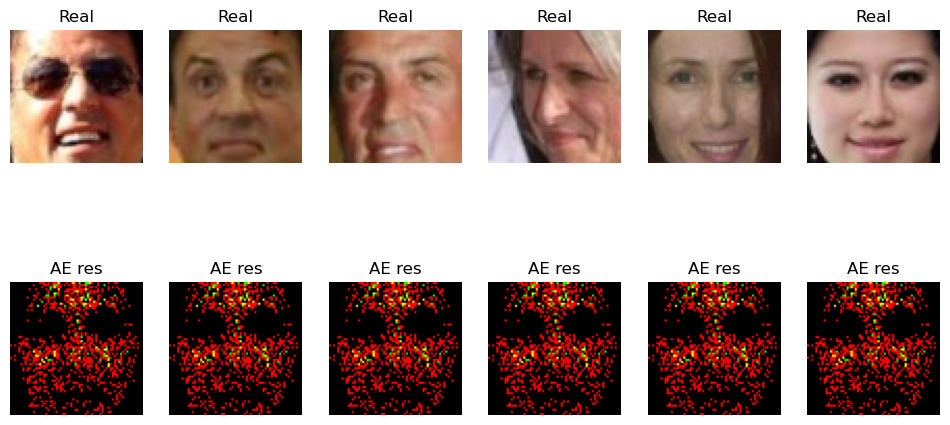

epo 30/30


In [26]:
bce_lin_ae = BCELinearAE(n_dim=128)
bce_lin_ae.to(device)

criterion = nn.BCEWithLogitsLoss() # <=============================================================================== и тут 
optimizer = torch.optim.AdamW(bce_lin_ae.parameters(), lr=3e-4)

n_epochs = 30
train_losses, val_losses = train_ae(autoencoder=bce_lin_ae, train_dl=train_dl,
                                    test_dl=test_dl, criterion=criterion,
                                    optimizer=optimizer, n_epochs=n_epochs, test_ds=test_ds, show_in_epo=False)

In [27]:


class  BCELinearAE(nn.Module):
    def __init__(self, n_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*64*64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 258),
            nn.ReLU(),
            nn.Linear(258, n_dim) # Latent dim size
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_dim, 258),
            nn.ReLU(),
            nn.Linear(258, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*64*64),
            nn.Sigmoid() # <<<================================================================================тут изменение
        )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code).view(-1, 3, 64, 64)
        return reconstruction, latent_code


In [30]:
bce_lin_ae = BCELinearAE(n_dim=128)
bce_lin_ae.to(device)

criterion = nn.BCELoss() # <=============================================================================== и тут 
optimizer = torch.optim.AdamW(bce_lin_ae.parameters(), lr=3e-4)

n_epochs = 30
train_losses, val_losses = train_ae(autoencoder=bce_lin_ae, train_dl=train_dl,
                                    test_dl=test_dl, criterion=criterion,
                                    optimizer=optimizer, n_epochs=n_epochs, test_ds=test_ds, show_in_epo=False)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
